In [20]:
import pickle
import pdb
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.graph_objects as go

In [2]:
with open('../data/final_data.pkl', 'rb') as file:
    final_df = pickle.load(file)
    
final_df.dropna(inplace=True)

In [3]:
final_df.head()

,building_rating_id,building_name,address,city,state,zipcode,2010_population,total_income,num_dependents,num_unemployed
0,2.0,courtyard apartments,524 Chiechi Ave,San Jose,CA,95126,31049,314336.000000,1598.333333,138.333333
1,3.0,parkview apartments,360 Meridian Ave,San Jose,CA,95126,31049,314336.000000,1598.333333,138.333333
2,2.0,courtyard apartments,38665 E 11th St,Palmdale,CA,93550,74929,178149.333333,5235.000000,291.666667
3,2.0,courtyard apartments,38675 12th St E,Palmdale,CA,93550,74929,178149.333333,5235.000000,291.666667
4,2.0,courtyard apartments,800 Main St,Van Meter,IA,50261,2211,19393.333333,155.000000,6.666667


In [4]:
def clean_name(name):
    if name == 'park place':
        return 'park place apartments'
    if name == 'parkview' or name == 'parkview apartments':
        return 'park view apartments'
    return name
    
final_df.building_name = final_df.building_name.apply(clean_name)

In [38]:
final_df = final_df.groupby(['zipcode', 'building_name', 'state']).mean().reset_index()
final_df['count'] = 1
final_df.head()

,zipcode,building_name,state,building_rating_id,2010_population,total_income,num_dependents,num_unemployed,count
0,01103,park view apartments,MA,2.0,2479,6767.833333,76.666667,8.333333,1
1,01108,park view apartments,MA,2.0,26688,70150.000000,1478.333333,130.000000,1
2,01247,riverview apartments,MA,2.0,16087,47606.000000,501.666667,86.666667,1
3,01519,riverview apartments,MA,2.0,6595,72517.000000,371.666667,26.666667,1
4,01605,park view apartments,MA,3.0,26221,88655.000000,1340.000000,106.666667,1


In [40]:
state_count = final_df.groupby(['building_name', 'state']).agg('sum')\
.reset_index()[['building_name', 'state', 'count']].rename(columns={'count':'total_in_state'})

final_df.drop('count', axis=1, inplace=True)

state_count[state_count.building_name == 'courtyard apartments']

,building_name,state,total_in_state
0,courtyard apartments,AL,2
1,courtyard apartments,AR,1
2,courtyard apartments,AZ,3
3,courtyard apartments,CA,23
4,courtyard apartments,CO,2
5,courtyard apartments,DE,1
6,courtyard apartments,FL,2
7,courtyard apartments,GA,1
8,courtyard apartments,IA,2
9,courtyard apartments,ID,3


In [6]:
grouped_final_df = final_df.groupby(["building_name"]).mean()
grouped_final_df

,building_rating_id,2010_population,total_income,num_dependents,num_unemployed
building_name,,,,,
courtyard apartments,2.352941,35305.435294,164061.980392,1842.274510,119.431373
hillcrest apartments,2.273684,25490.715789,131547.598246,1195.543860,87.771930
park place apartments,2.484848,31224.324675,158085.680375,1474.126984,97.106782
park view apartments,2.429268,31571.107317,153307.308943,1592.439024,110.097561
parkside apartments,2.366667,32164.778947,163646.877193,1608.175439,101.280702
riverview apartments,2.280822,23968.424658,107615.783105,1020.182648,73.926941


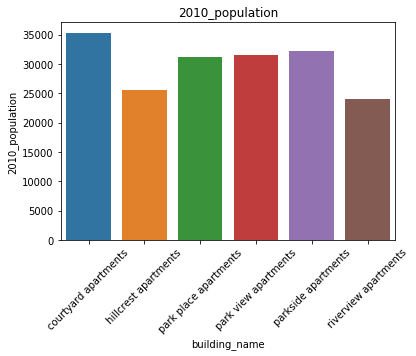

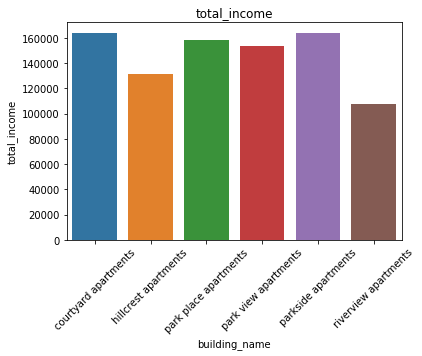

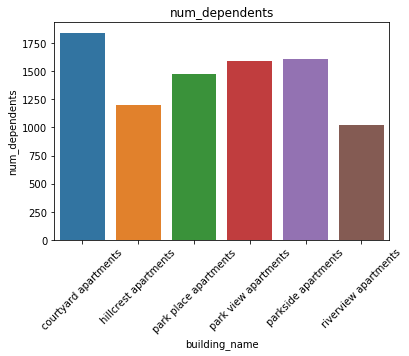

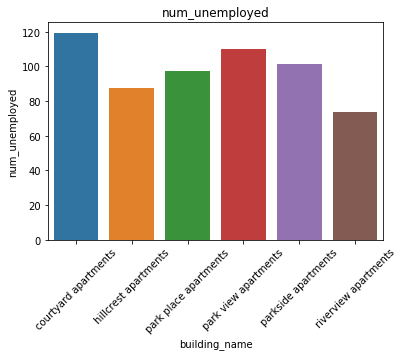

In [7]:
features = ['2010_population', 'total_income', 'num_dependents', 'num_unemployed']

for feat in features:

    sns.barplot(x=grouped_final_df.index, y=feat, data=grouped_final_df)
    plt.title(feat)
    plt.xticks(rotation=45)
    plt.show()

In [47]:
feature_ranges = {
    "2010_population": dict(title="Average Population Per zip code", crange=[1_000, 70_000, 10_000]),
    "total_income": dict(title="Average household income by zip code", crange=[5_000, 420_000, 100_000]),
    "num_dependents": dict(title="Average number dependents reported by zip code", crange=[20, 3_000, 300]),
    "num_unemployed": dict(title="Average number unemployed reported by zip code", crange=[0, 500, 50]),
    "total_in_state": dict(title="Total locations in state", crange=[1, 50, 5])
}

In [50]:
def map_feature(feature_ranges, feature):
    for company in final_df.building_name.unique():

        current_df = final_df[final_df.building_name == company]
        current_df = current_df.groupby(['state']).mean().reset_index()
        
        current_state_count = state_count[state_count.building_name == company][['state', 'total_in_state']]
        current_df = current_df.merge(current_state_count, on=['state'])

        fig = go.Figure(data=go.Choropleth(
            locations=current_df['state'],
            z=current_df[feature],
            zmin=feature_ranges[feature]['crange'][0],
            zmax=feature_ranges[feature]['crange'][1],
            locationmode='USA-states',         
            colorbar=dict(
                tickmode='array',
                tickvals=list(range(*feature_ranges[feature]['crange'])),
                ticks='outside',
            ),
        ))

        fig.update_layout(
            title_text=f"{company.title()}: {feature_ranges[feature]['title']}",
            geo_scope='usa'
        )

        fig.show()

map_feature(feature_ranges, 'total_in_state')